# I] Import, options

In [1]:
import numpy, seaborn, pandas
import matplotlib, matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(8, 5), 'svg.fonttype' : 'none'})

In [3]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# II] Data Download

In [4]:
#data hNPC all H3K36me3
df_H3K36me3 = pandas.read_csv(file_directory+'1) input/HEK293_H3K36me3_diffPeaks_max20_37KOvs37wt.csv',
                               sep = ',')

# select columns
columns = ['SYMBOL','Fold','FDR','annotation']
print(df_H3K36me3.shape)
df_H3K36me3[columns].head(5)

(249710, 36)


,SYMBOL,Fold,FDR,annotation
0,MIR4289,5.552725,0.000584,Distal Intergenic
1,MEX3C,5.621872,0.000584,"Intron (ENST00000406189.4/51320, intron 1 of 1)"
2,TFB1M,5.448008,0.000584,Promoter (<=1kb)
3,SNORA30,-5.145810,0.000645,Promoter (<=1kb)
4,THOC2,5.352110,0.000645,"Exon (ENST00000245838.13/57187, exon 11 of 39)"


In [5]:
#p.value is probably not adj.p.value

# III] VolcanoPlot

In [6]:
#define the colors
df_H3K36me3 = df_H3K36me3[df_H3K36me3['FDR'] < 1]
colors = ['blue' if x < -3.7 and -numpy.log10(y) > 2
          else 'red' if x > 3.7 and -numpy.log10(y) > 2
          else 'black' if x > -1 and x < 1
          else 'grey' for x, y in zip(df_H3K36me3['Fold'], df_H3K36me3['FDR'])]

blue_indices = [symbol for symbol, color in zip(df_H3K36me3['SYMBOL'], colors) if color == 'blue']
red_indices = [symbol for symbol, color in zip(df_H3K36me3['SYMBOL'], colors) if color == 'red']
grey_indices = [symbol for symbol, color in zip(df_H3K36me3['SYMBOL'], colors) if color == 'grey']

blue_genes_n = len(set(blue_indices))
red_genes_n = len(set(red_indices))
grey_genes_n = len(set(grey_indices))

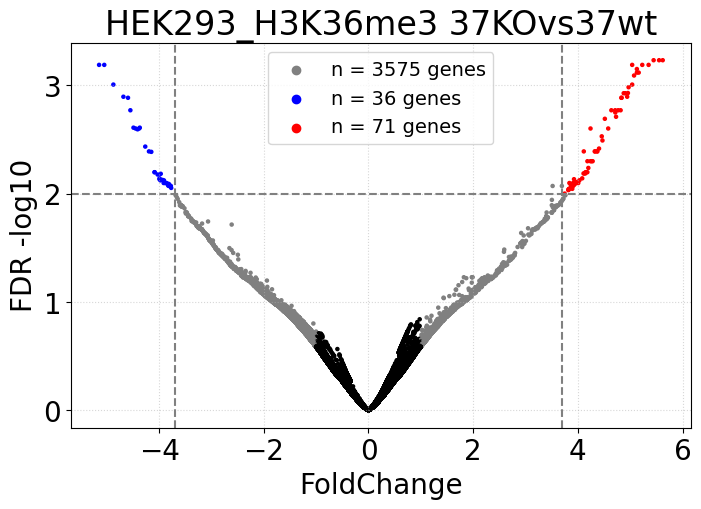

In [7]:
#volcano plot
# Plot, after convertion  y to log10(pvalue)
plt.scatter(x=df_H3K36me3['Fold'],y=df_H3K36me3['FDR'].apply(lambda x:-numpy.log10(x)),
            s=5,  c=colors)

plt.scatter(x=[],y=[], marker="o", color='grey', label= f'n = {grey_genes_n} genes')
plt.scatter(x=[],y=[], marker="o", color='blue', label= f'n = {blue_genes_n} genes')
plt.scatter(x=[],y=[], marker="o", color='red', label= f'n = {red_genes_n} genes')

plt.legend(fontsize = '14')
plt.title('HEK293_H3K36me3 37KOvs37wt')
plt.xlabel("FoldChange")
plt.ylabel("FDR -log10")

plt.axvline(-3.7,color="grey",linestyle="--")
plt.axvline(3.7,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")

title_file = 'volcano_HEK293_H3K36me3_MACS3'
plt.savefig(file_directory+'3) output/'+title_file+'.svg')

## IV] Heatmap

In [8]:
df_H3K36me3.shape

(62966, 36)

In [9]:
#select the interesting genes
df_hm = df_H3K36me3[ (df_H3K36me3['Fold'] > 3.7) | (df_H3K36me3['Fold'] < -3.7) ]

log_p_value = 2
p_value = 10**(-log_p_value)

df_hm = df_hm[ (df_hm['p.value'] < p_value) ]
print(f"highest pvalue is {df_hm['p.value'].max()}")

df_hm = df_hm[['SYMBOL', 'Fold','p.value']]
print(df_hm.shape)
# save this results
# df_hm.to_csv('{}/1) input/from_output/highest_NPC_H3K36me3_MACS3.csv'.format(file_directory), sep=',')
df_hm.head()

highest pvalue is 2.15900410918274e-05
(112, 3)


,SYMBOL,Fold,p.value
0,MIR4289,5.552725,2.461157e-08
1,MEX3C,5.621872,2.475970e-08
2,TFB1M,5.448008,3.712064e-08
3,SNORA30,-5.145810,6.103413e-08
4,THOC2,5.352110,6.949019e-08


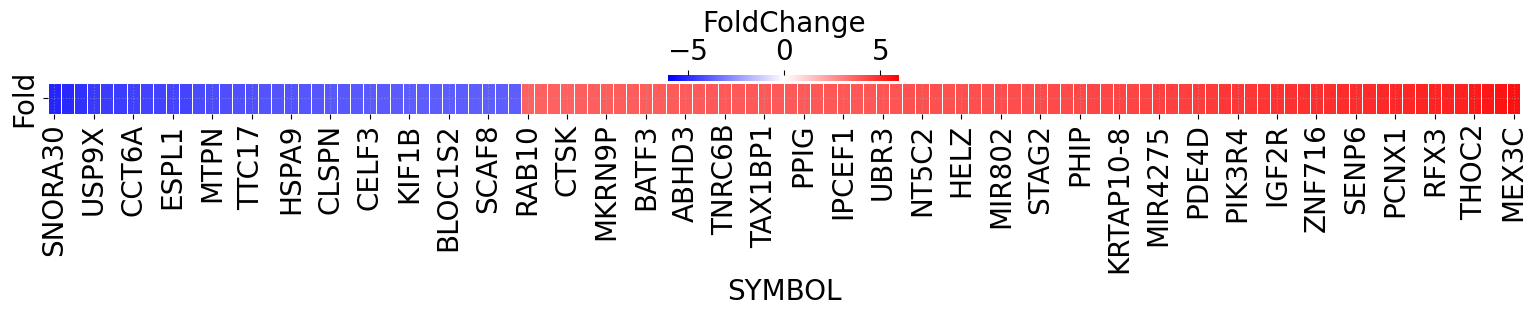

In [10]:
data = df_hm[['SYMBOL','Fold']]
data = data.sort_values(['Fold'], ascending = True)
data.set_index('SYMBOL', inplace= True)

plt.subplots(figsize=(19,0.5))
seaborn.heatmap(data.T, annot=False, cmap="bwr", linewidths=.5, center=0, vmin=-6, vmax=6,
               cbar_kws={'label': 'FoldChange', 'location' : 'top', 'orientation': 'horizontal',
                        'aspect': 40})

title_file = 'Heatmap_HEK293_H3K36me3_MACS3'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [11]:
# save the list to csv
df_hm.sort_values(['Fold'], ascending = True)
df_hm.to_csv('{}/1) input/from_output/HEK293_H3K36me3_topgenes.csv'.format(file_directory), 
             index= False, sep=',')

# V] Classification by annotation

In [12]:
#to see the different kind of annotation 
# set(df_H3K36me3.annotation)

In [13]:
# create a function to simplufy the annotation
def get_annotation_category(annotation):
    if annotation.startswith('Intron'):
        return 'Intron'
    elif annotation.startswith('Exon'):
        return 'Exon'
    elif annotation.startswith('Promoter'):
        return 'Promoter'
    else:
        return annotation

In [14]:
df_H3K36me3 = df_H3K36me3.assign(Annotation = df_H3K36me3['annotation'].apply(get_annotation_category))
df_H3K36me3 = df_H3K36me3[['SYMBOL', 'Fold', 'p.value', 'FDR', 'Annotation']]
print(set(df_H3K36me3.Annotation), '\n')

df_H3K36me3['Annotation'] = df_H3K36me3['Annotation'].str.strip()
df_H3K36me3

{'Distal Intergenic', 'Promoter', 'Intron', 'Exon', "5' UTR", 'Downstream (<=300bp)', "3' UTR"} 



,SYMBOL,Fold,p.value,FDR,Annotation
0,MIR4289,5.552725,2.461157e-08,0.000584,Distal Intergenic
1,MEX3C,5.621872,2.475970e-08,0.000584,Intron
2,TFB1M,5.448008,3.712064e-08,0.000584,Promoter
3,SNORA30,-5.145810,6.103413e-08,0.000645,Promoter
4,THOC2,5.352110,6.949019e-08,0.000645,Exon
...,...,...,...,...,...
62961,UFD1,-0.000023,9.999327e-01,0.999986,Promoter
62962,MIR6814,0.000019,9.999453e-01,0.999986,Intron
62963,LOC124903402,0.000014,9.999546e-01,0.999986,Distal Intergenic
62964,CDK5RAP2,0.000005,9.999850e-01,0.999990,Intron


In [15]:
df_H3K36me3.Annotation.value_counts()

Intron                  28517
Promoter                22673
3' UTR                   5066
Exon                     4311
Distal Intergenic        1986
5' UTR                    354
Downstream (<=300bp)       59
Name: Annotation, dtype: int64

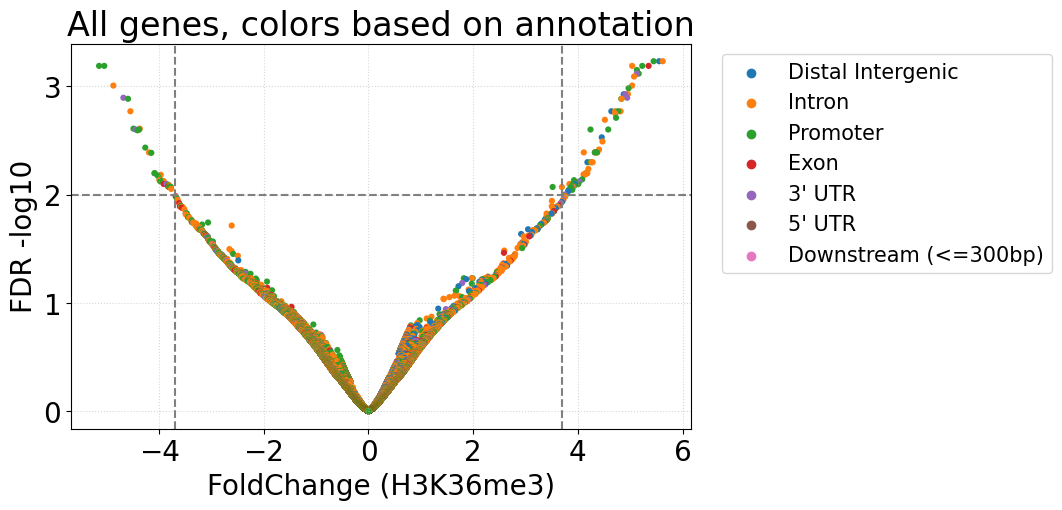

In [26]:
seaborn.scatterplot(data=df_H3K36me3, x=df_H3K36me3['Fold'], 
                    y=df_H3K36me3['FDR'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Annotation")

plt.legend(loc='upper right', bbox_to_anchor=(1.60, 1), fontsize='15')

plt.title('All genes, colors based on annotation')
plt.xlabel("FoldChange (H3K36me3)")
plt.ylabel("FDR -log10")

plt.axvline(-3.7,color="grey",linestyle="--")
plt.axvline(3.7,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")

title_file = 'volcano_hNPC_H3K36me3_all_annotation'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [17]:
# Check up to see if its true (yes, the colors fit to the annotation)
log_p_value = 2
p_value = 10**(-log_p_value)

df_ctl = df_H3K36me3[ (df_H3K36me3['Fold'] > 1) & (df_H3K36me3['FDR'] < p_value)]
df_ctl.sort_values('Fold').head()

,SYMBOL,Fold,p.value,FDR,Annotation
95,SLC7A11,3.518525,0.000013,0.008481,Promoter
94,VMP1,3.695474,0.000013,0.008481,Intron
108,CTSK,3.748194,0.000017,0.009971,3' UTR
107,MKRN9P,3.817721,0.000016,0.009263,Distal Intergenic
106,CEP63,3.824412,0.000016,0.009182,Promoter


## CNOT1 has transcript switch. How is H3K36me3 of it?

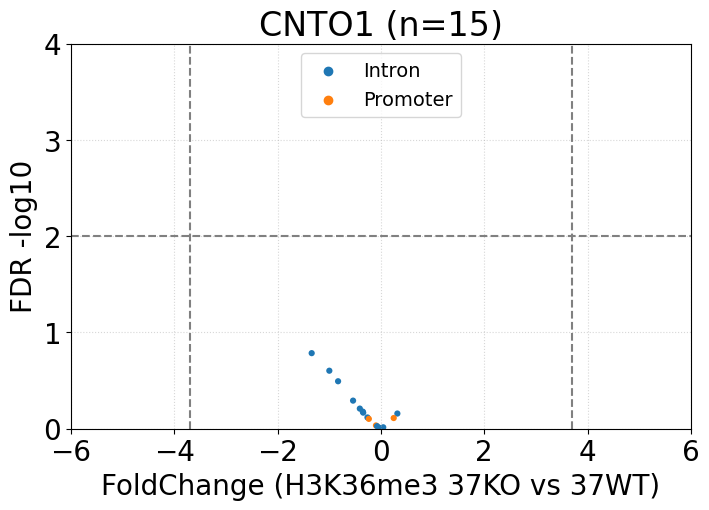

In [32]:
df_CNOT1 = df_H3K36me3[df_H3K36me3['SYMBOL'] == 'CNOT1']

seaborn.scatterplot(data=df_CNOT1, x=df_CNOT1['Fold'], 
                    y=df_CNOT1['FDR'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Annotation")

plt.legend(fontsize='14')

plt.title('CNTO1 (n=15)')
plt.xlim(-6, 6)
plt.ylim(0, 4)
plt.xlabel("FoldChange (H3K36me3 37KO vs 37WT)")
plt.ylabel("FDR -log10")

plt.axvline(-3.7,color="grey",linestyle="--")
plt.axvline(3.7,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")